Importing Datasets

In [58]:
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
import requests
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
warnings.filterwarnings('ignore')
%matplotlib inline

Data Acquisition

In [59]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

train = pd.read_csv('../input/covid19-global-forecasting-week-4/train.csv')
test = pd.read_csv('../input/covid19-global-forecasting-week-4/test.csv')
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

Prediction using Growth Factor

In [60]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()
countries = ['China','US', 'Italy', 'Spain', 'France','India']
global_confirmed = []
for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0])
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

In [61]:
k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0]
growth_diff = []
for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])
growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.074124821293029


Prediction for next 15 days

In [62]:
prediction_dates = []

start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][len(dates_india) - 1]
predicted_cases = []

In [63]:
for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

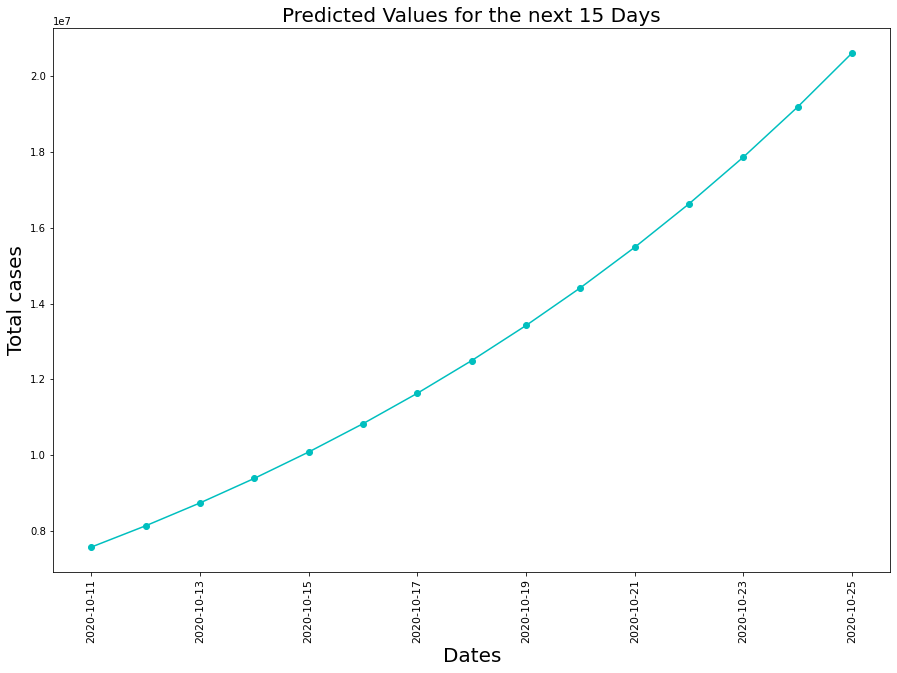

In [64]:
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')

Prediction using ARIMA Model

In [65]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed

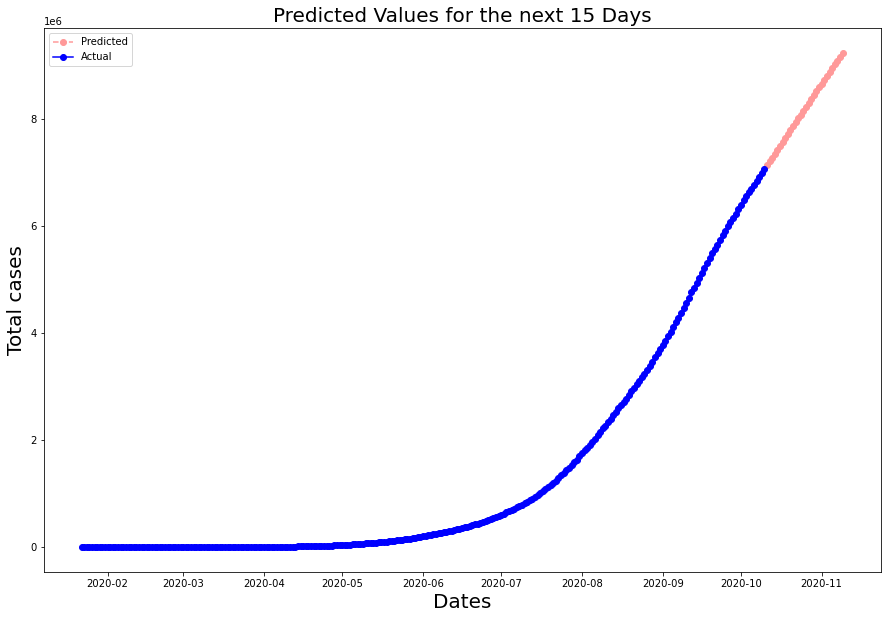

In [66]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

Prediction using Prophet Model

In [67]:
confirmedcases_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df1 = confirmedcases_df.groupby('Country/Region').sum().reset_index()
df1


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20
0,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,...,39285,39290,39297,39341,39422,39486,39548,39616,39693,39703
1,Albania,41.153300,20.168300,0,0,0,0,0,0,0,...,13806,13965,14117,14266,14410,14568,14730,14899,15066,15231
2,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,...,51690,51847,51995,52136,52270,52399,52520,52658,52804,52940
3,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,...,2050,2110,2110,2110,2370,2370,2568,2568,2696,2696
4,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,...,5114,5211,5370,5402,5530,5725,5725,5958,6031,6246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,...,40322,40766,41078,41498,41957,42432,42840,43256,43664,43945
184,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
185,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,...,2039,2040,2041,2041,2041,2047,2049,2050,2051,2051
186,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,...,14802,14830,14974,15052,15089,15170,15224,15301,15339,15415


In [68]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
confirmedcases_India = k.values.tolist()[0]
confirmedcases_India

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 5,
 5,
 28,
 30,
 31,
 34,
 39,
 43,
 56,
 62,
 73,
 82,
 102,
 113,
 119,
 142,
 156,
 194,
 244,
 330,
 396,
 499,
 536,
 657,
 727,
 887,
 987,
 1024,
 1251,
 1397,
 1998,
 2543,
 2567,
 3082,
 3588,
 4778,
 5311,
 5916,
 6725,
 7598,
 8446,
 9205,
 10453,
 11487,
 12322,
 13430,
 14352,
 15722,
 17615,
 18539,
 20080,
 21370,
 23077,
 24530,
 26283,
 27890,
 29451,
 31324,
 33062,
 34863,
 37257,
 39699,
 42505,
 46437,
 49400,
 52987,
 56351,
 59695,
 62808,
 67161,
 70768,
 74292,
 78055,
 81997,
 85784,
 90648,
 95698,
 100328,
 106475,
 112028,
 118226,
 124794,
 131423,
 138536,
 144950,
 150793,
 158086,
 165386,
 173491,
 181827,
 190609,
 198370,
 207191,
 216824,
 226713,
 236184,
 246622,
 257486,
 265928,
 276146,
 286605,
 297535,
 308993,
 320922,
 332424,
 343091,
 354065,
 366946,
 380532,
 395048,
 410451,
 

In [69]:
data=pd.DataFrame(columns=['ds','y'])
dates = list(confirmedcases_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates

[Timestamp('2020-01-22 00:00:00'),
 Timestamp('2020-01-23 00:00:00'),
 Timestamp('2020-01-24 00:00:00'),
 Timestamp('2020-01-25 00:00:00'),
 Timestamp('2020-01-26 00:00:00'),
 Timestamp('2020-01-27 00:00:00'),
 Timestamp('2020-01-28 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-01-30 00:00:00'),
 Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-02-02 00:00:00'),
 Timestamp('2020-02-03 00:00:00'),
 Timestamp('2020-02-04 00:00:00'),
 Timestamp('2020-02-05 00:00:00'),
 Timestamp('2020-02-06 00:00:00'),
 Timestamp('2020-02-07 00:00:00'),
 Timestamp('2020-02-08 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2020-02-10 00:00:00'),
 Timestamp('2020-02-11 00:00:00'),
 Timestamp('2020-02-12 00:00:00'),
 Timestamp('2020-02-13 00:00:00'),
 Timestamp('2020-02-14 00:00:00'),
 Timestamp('2020-02-15 00:00:00'),
 Timestamp('2020-02-16 00:00:00'),
 Timestamp('2020-02-17 00:00:00'),
 Timestamp('2020-02-18 00:00:00'),
 Timestamp('2020-02-

In [70]:
data['ds'] = dates
data['y'] = confirmedcases_India
data

,ds,y
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
258,2020-10-06,6757131
259,2020-10-07,6835655
260,2020-10-08,6906151
261,2020-10-09,6979423


In [71]:
prop= Prophet()
prop.fit(data)
future = prop.make_future_dataframe(periods=30)
prop_forecast = prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)
forecast

,ds,yhat
263,2020-10-11,7.193524e+06
264,2020-10-12,7.274093e+06
265,2020-10-13,7.356759e+06
266,2020-10-14,7.441058e+06
267,2020-10-15,7.525147e+06
268,2020-10-16,7.609195e+06
269,2020-10-17,7.693119e+06
270,2020-10-18,7.777855e+06
271,2020-10-19,7.858423e+06
272,2020-10-20,7.941089e+06


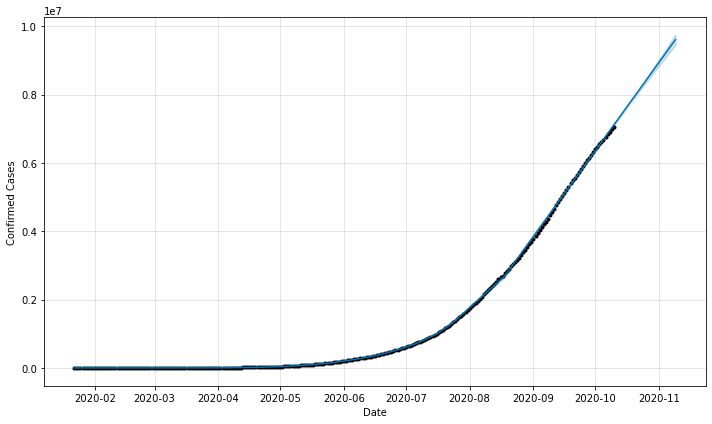

In [72]:
fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

Preprocessing for 3 Regressors( LightGBM, XGBoost, Random Forest)

In [73]:
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['dayofweek'] = train['Date'].dt.dayofweek
train['dayofyear'] = train['Date'].dt.dayofyear
train['quarter'] = train['Date'].dt.quarter
train['weekofyear'] = train['Date'].dt.weekofyear
test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['dayofweek'] = test['Date'].dt.dayofweek
test['dayofyear'] = test['Date'].dt.dayofyear
test['quarter'] = test['Date'].dt.quarter
test['weekofyear'] = test['Date'].dt.weekofyear
countries = list(train['Country_Region'].unique())
india_code = countries.index('India')
train = train.drop(['Date','Id'],1)
test =  test.drop(['Date'],1)

train.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
train[['Province_State','Country_Region']] = oe.fit_transform(train.loc[:,['Province_State','Country_Region']])

test.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
test[['Province_State','Country_Region']] = oe.fit_transform(test.loc[:,['Province_State','Country_Region']])

In [74]:
columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region','ConfirmedCases','Fatalities']
test_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State','Country_Region']
train = train[columns]
x = train.drop(['Fatalities','ConfirmedCases'], 1)
y = train['ConfirmedCases']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
test = test[test_columns]
test_india = test[test['Country_Region'] == india_code]

In [75]:
models = []
mse = []
mae = []
rmse = []

LGBM Regressor Implementation

In [76]:
lgbm = LGBMRegressor(n_estimators=1300)
lgbm.fit(x_train,y_train)
pred = lgbm.predict(x_test)
lgbm_forecast = lgbm.predict(test_india)
models.append('LGBM')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

Random Forest Regressor Implementation

In [77]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
rfr_forecast = rf.predict(test_india)
models.append('Random Forest')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

XGB Regressor Implementation

In [78]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(x_train,y_train)
pred = xgb.predict(x_test)
xgb_forecast = xgb.predict(test_india)
models.append('XGBoost')
mse.append(round(mean_squared_error(pred, y_test),3))
mae.append(round(mean_absolute_error(pred, y_test),3))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),3))

Accuracy check for all the three regressors 

In [79]:
print(models)
print(mse)
print(mae)
print(rmse)

['LGBM', 'Random Forest', 'XGBoost']
[1777777.79, 541922.31, 3946492.271]
[441.5, 157.89, 701.994]
[1333.33, 736.15, 1986.578]
